In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2022-12-03 16:43:53.117412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 10

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2022-12-03 16:44:12.212926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
13/14 [==========================>...] - ETA: 0s - loss: 2.3444 - accuracy: 0.1220 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 3s 61ms/step - loss: 2.3420 - accuracy: 0.1200 - val_loss: 2.2854 - val_accuracy: 0.1647
Epoch 2/1000
10/14 [====================>.........] - ETA: 0s - loss: 2.3115 - accuracy: 0.1250
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 13ms/step - loss: 2.3014 - accuracy: 0.1319 - val_loss: 2.2610 - val_accuracy: 0.2784
Epoch 3/1000
10/14 [====================>.........] - ETA: 0s - loss: 2.2775 - accuracy: 0.1562
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
14/14 [==============================] - 0s 14ms/step - loss: 2.2784 - accuracy: 0.1540 - val_loss: 2.2474 - val_accuracy: 0.2699
Epoch 4/1000
12/14 [========================>.....] - ETA: 0s - loss: 2.2662 - accuracy: 0.16

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 2ms/step - loss: 0.7147 - accuracy: 0.8149


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 118ms/step
[1.2872584e-09 9.2695285e-10 5.3947009e-05 2.8673090e-13 7.1634795e-11
 2.4604146e-10 2.2462878e-04 9.9959534e-01 2.3960781e-13 1.2609764e-04]
7


# 混同行列

19/19 [==============================] - 0s 2ms/step


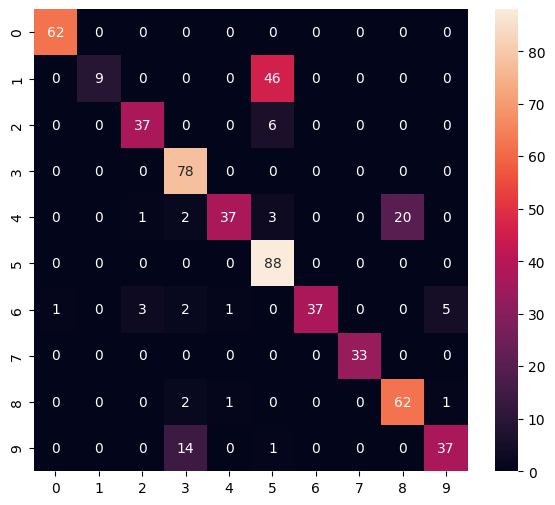

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      0.16      0.28        55
           2       0.90      0.86      0.88        43
           3       0.80      1.00      0.89        78
           4       0.95      0.59      0.73        63
           5       0.61      1.00      0.76        88
           6       1.00      0.76      0.86        49
           7       1.00      1.00      1.00        33
           8       0.76      0.94      0.84        66
           9       0.86      0.71      0.78        52

    accuracy                           0.81       589
   macro avg       0.89      0.80      0.80       589
weighted avg       0.86      0.81      0.79       589



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp1w_c2e9j/assets


2022-12-03 16:44:55.634985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-03 16:44:55.635342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-03 16:44:55.639568: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp1w_c2e9j
2022-12-03 16:44:55.649337: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-03 16:44:55.650046: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp1w_c2e9j
2022-12-03 16:44:55.662009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-03 16:44:55.664745: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-03 16:44:55.822105: I tensorflow/cc/saved_model/loader.

6808

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.5 ms, sys: 2.49 ms, total: 3.99 ms
Wall time: 4.05 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.2872609e-09 9.2695462e-10 5.3947060e-05 2.8673144e-13 7.1634795e-11
 2.4604194e-10 2.2462920e-04 9.9959534e-01 2.3960781e-13 1.2609776e-04]
7
